--------
## NLP Algorithm Development


### Building a Multi-Class Classifier

#### Overview
Create a multi-class classification problem using the “option_1.csv” dataset to classify the review text into each category. There is a list of 5K reviews for several product categories. 

#### Data
“Text” – A review given by a customer for a purchased item

“Cat” – A category for the item being reviewed

### 1. Data Loading and Understanding

In [ ]:
import pandas as pd
data = pd.read_csv("option_1.csv")
print("Dimension of data",data.shape)
print("Number of categories", len(data.Cat.unique()))

Dimension of data (5000, 2)
Number of categories 20


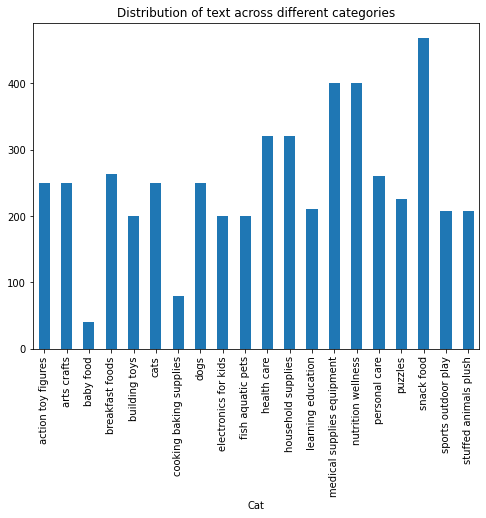

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('Cat').Text.count().plot.bar(ylim=0)
plt.title("Distribution of text across different categories")
plt.show()

### 2. Data Cleaning and Preparation

In [ ]:
from io import StringIO

data['category_id'] = data['Cat'].factorize()[0]
category_id_df = data[['Cat', 'category_id']].drop_duplicates().sort_values('category_id')

# Create dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Cat']].values)

data.head()

,Text,Cat,category_id
0,Hi! I'm Martine Redman and I created this puzz...,puzzles,0
1,120 colors? I say 120 sticks of fun! And a fre...,arts crafts,1
2,"What a wonderful creation. Art, in our house, ...",arts crafts,1
3,"Meowth is the coolest, lots of play value. Gre...",action toy figures,2
4,You can give a MagnaDoodle to any kid who's ab...,arts crafts,1


In [ ]:
category_to_id

{'puzzles': 0,
 'arts crafts': 1,
 'action toy figures': 2,
 'personal care': 3,
 'nutrition wellness': 4,
 'learning education': 5,
 'electronics for kids': 6,
 'household supplies': 7,
 'stuffed animals plush': 8,
 'health care': 9,
 'medical supplies equipment': 10,
 'building toys': 11,
 'sports outdoor play': 12,
 'cats': 13,
 'dogs': 14,
 'breakfast foods': 15,
 'cooking baking supplies': 16,
 'snack food': 17,
 'baby food': 18,
 'fish aquatic pets': 19}

### 3. Text Representation using TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data.Text).toarray()
labels = data.category_id
features.shape

(5000, 6001)

Now, each of 5000 user reviews is represented by 6001 features, representing the tf-idf score for different unigrams and bigrams.

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2

for Cat, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Cat))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'action toy figures':
  . Most correlated unigrams:
. figure
. figures
  . Most correlated bigrams:
. optimus prime
. action figure
# 'arts crafts':
  . Most correlated unigrams:
. easel
. crayons
  . Most correlated bigrams:
. making mess
. dry erase
# 'baby food':
  . Most correlated unigrams:
. peach
. formula
  . Most correlated bigrams:
. right door
. earth best
# 'breakfast foods':
  . Most correlated unigrams:
. cereal
. bars
  . Most correlated bigrams:
. cherry cashew
. snack bars
# 'building toys':
  . Most correlated unigrams:
. blocks
. lego
  . Most correlated bigrams:
. lego sets
. lego set
# 'cats':
  . Most correlated unigrams:
. litter
. cats
  . Most correlated bigrams:
. cats love
. litter box
# 'cooking baking supplies':
  . Most correlated unigrams:
. cake
. bread
  . Most correlated bigrams:
. wait try
. gluten free
# 'dogs':
  . Most correlated unigrams:
. dogs
. dog
  . Most correlated bigrams:
. dogs love
. dog loves
# 'electronics for kids':
  . Most correla

### 4. Multi-Class Classifier: Features and Design

To train supervised classifiers, we first transformed the reviews into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.
After having this vector representations of the text we can train supervised classifiers to train unseen use re iews and predict the “category” in which they fall.

#### Naive Bayes Classifier

Using one of most suitable for word counts is the multinomial variant

In [ ]:
# Model fitting 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Cat'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

####  Checking the prediction of the model

In [ ]:
pd.set_option('display.max_colwidth', None)
data.iloc[0:1,0:2].Text

0    Hi! I'm Martine Redman and I created this puzzle for Briarpatch using a great photo from Jean Marzollo and Walter Wick's terrific book, I Spy School Days. Kids need lots of practice to master the ABC's, and this puzzle provides an enjoyable reinforcing tool. Its visual richness helps non-readers and readers alike to remember word associations, and the wealth of cleverly chosen objects surrounding each letter promote language development. The riddle included multiplies the fun of assembling this colorful puzzle. For another great Briarpatch puzzle, check out I Spy Blocks. END
Name: Text, dtype: object

In [ ]:
print(clf.predict(count_vect.transform(["Hi! I'm Martine Redman and I created this puzzle for Briarpatch using a great photo from Jean Marzollo and Walter Wick's terrific book, I Spy School Days. Kids need lots of practice to master the ABC's, and this puzzle provides an enjoyable reinforcing tool. Its visual richness helps non-readers and readers alike to remember word associations, and the wealth of cleverly chosen objects surrounding each letter promote language development. The riddle included multiplies the fun of assembling this colorful puzzle. For another great Briarpatch puzzle, check out I Spy Blocks. "])))

['puzzles']


Seems to provide decent results

### 5. Model Selection

Now I will experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

I will benchmark the following four models:
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

/Users/sharvitomar/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


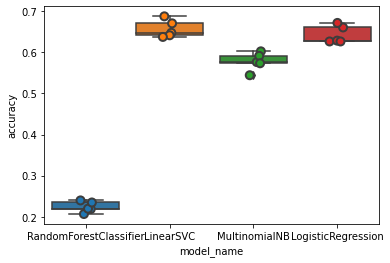

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.6564
LogisticRegression        0.6422
MultinomialNB             0.5772
RandomForestClassifier    0.2242
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 65.64%.

### 6. Model Evaluation

With the best model (LinearSVC), I am going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

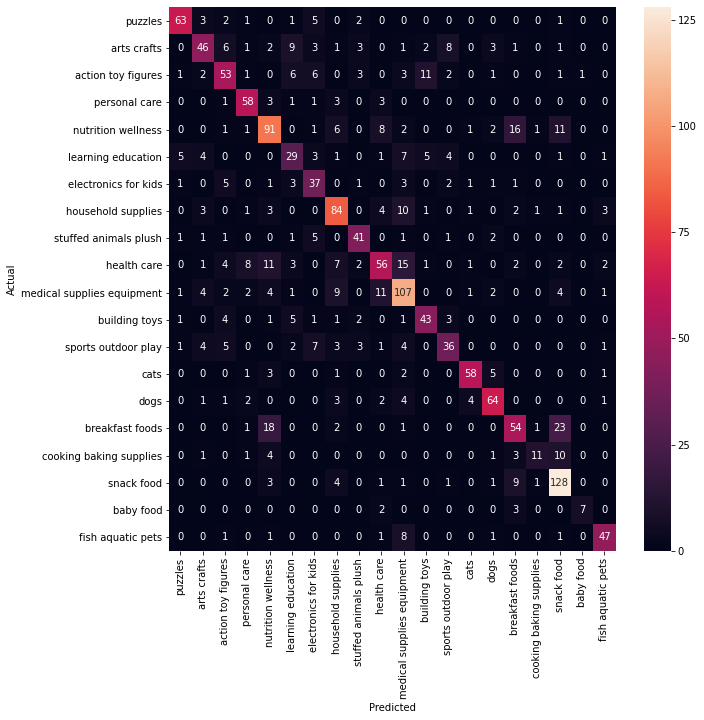

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Cat.values, yticklabels=category_id_df.Cat.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Cat', 'Text']])
            print('')

'health care' predicted as 'nutrition wellness' : 11 examples.


,Cat,Text
138,health care,"These tablets claim to taste better than most other antacids and that point is true...there isn't the nasty chalky aftertaste that other antacids have. However, other than that, Amitone works the same as all the other antacids. I cannot tell any difference with Amitone over the others. So, if you're tired of the aftertaste of other antacids, try Amitone."
137,health care,"This product seems little better than similar products I've tried. I think the taste is better, but there's the same residue left in your mouth after chewing it thoroughly and swallowing. It helps with acid stomach as it's advertised. I wouldn't hesitate to recommend it, but I wouldn't recommend it above others I've tried."
117,health care,"I wouldn't recommend this to anyone. I tried several different sizes of tablets, pills, and vitamins -- everything I had in the house. It just crushed everything into powder. The instructions were no help at all. I couldn't figure out which direction the tablets should go in. I tried every way and no results. This product isn't worth the money."
2100,health care,"The calories and fat are far less than a candy bar, and it's far more satisfying. I don't get nearly enough vitamins, and these bars give me a better start. There's no corn syrup, plenty of protein, and so many vitamins I found a few I didn't recognize.Amazon has a great price for 15 bars, less than a dollar a piece! Don't be afraid to try these! The Peppermint Stick bars taste just like thin mint Girl Scout Cookies! I like Caramel Nut Brownie too, in fact, the only one that didn't fit my tastes was the Lemon Zest.They're fit for a lady's health, but I'm very sure anyone can enjoy these."
1695,health care,"I have been taking Prilosec OTC for quite awhile now. After trying many other products with no results. Prilosec OTC seemed to be the only one that worked and keeps on working around the clock.Prilosec OTC Is the only Acid Reducer Medicine I buy now and I highly recommend for anyone to give It a shot and see If you don't agree after trying It.It does state on the box, that the product shouldn't be taken for the required number of days. You can take this product as long as you need to, but consult with your Doctor before you do.I've learnt this after consulting with my Doctor and he said that I could take this for as long as I needed.Which I was very pleased, because I couldn't Imagine not being to continue on daily without Prilosec OTC."
1009,health care,"Chai tea is the blue ribbon of my luna experience. Not too sweet, yet exotic and full bodied. Lightly coated with yogurt, there are little bits of tea leaves inside. Perfect mid-morning snack."
1815,health care,This product is the best in sleep aids I have used. Wigh my hectic schedule it's nice to know I have a great quality product I can count on.
2472,health care,"I have used this stuff for a few years, mostly for bruises, but when I broke my big toe it really seemd to help it heal very quickly,not just clearing the blood under the nail, (which I didn't loose), but helped with the pain. It also seemed to help with a case of tendonitis I had in my ankle. Its non greasy. It works so well that when my 8 yr old smashed his finger while working he wouldn't let me put it on because he didn't want it to make his ""trophy"" go away before his buddies could see it!"
2832,health care,We've been using this glucosamine powder in our protien drinks every morning for several years now. I was dubious about it at first but it's the only thing to which I can attribute the lessening of aching in my joints.It has the recommended other ingredients that should be taken along with glucosamine which many supplements don't.
2017,health care,This is one of the best products that I have used or have had as an service used. My nail salon just started using this product as well. It really softens the roughness and callus so that they are easily removed.



'breakfast foods' predicted as 'nutrition wellness' : 18 examples.


,Cat,Text
4836,breakfast foods,"Bought four of these at Target and unfortunately used the receipt to get rid of some chewing gum -- have been buying them for years, and generally enjoy them. Will never buy in quantity again. They're all STALE. Not the first time I've noticed that happening much earlier than the sell by date, either. Caveat emptor (buyer beware)."
4672,breakfast foods,"I ordered and received 3 boxes of Think Thin bars,the Chocolate mudslide bars I got were not fresh. The others were good.Maybe because people don't order them as often as other bars - it got old.Since then I have stopped ordering those Chocolate mudslide bars."
4452,breakfast foods,"My experiences with health and energy bars have been mixed. Most of the ones I've tried are pricey, taste terrible, and make me feel like I've swallowed powdered cement. So, I was cautious about Pure Bar. My general view, based on experience, is that the healthier and more ""organic"" it is, the worse it's going to be and this one is jam-packed with things like organic dates, organic cashews, organic rice protein concentrate, and other organic healthy stuff--so it couldn't possibly be delicious, right? Wrong. I was pleasantly surprised after the first bite hit my taste buds. These things are really good! Unlike most health bars I've tried, these are chewy and moist--not hard and dry. I don't have to wash this down with a drink in order to get it from my throat to my stomach, and there's no nasty aftertaste. And, the price is definitely reasonable! I'll be buying more of these for sure."
4366,breakfast foods,"I bought a box of the chocolate-coconut when it was on a lightning deal previously. When I think ""chocolate and coconut"" I think Mounds bar, and that's exactly what this tastes like, if you took a Mounds bar and replaced it with a giant hunk of dirt. This is no way tastes like chocolate. Stay away unless you actually like the taste of carob (which is fine, they just shouldn't call it chocolate), or you're one of those people who think Diet Coke tastes at all like regular Coke, in which case you clearly have no sense of taste anyway, so have at it."
4711,breakfast foods,Really really bad.All the other bars are so good we were looking forward to trying these.
4952,breakfast foods,I was excited about this flavor but so disappointed when I tried it. These are super-dense and really gross tasting. The brownie crunch and peanut butter (both chunky and creamy) varieties are a million times more edible.
1997,breakfast foods,"I love these bars! They are good for a meal replacement and have plenty of fiber. If you love chocolate, you should love these LARGE nutritious bars."
4208,breakfast foods,"This bar is one of my favorites. I love key lime pie. And it tastes just like key lime pie!It is truly amazing. There is no flour, sugar, eggs, chemicals, preservatives, or anything bad.There are only natural, healthy ingredients.This bar is suitable for vegans.This bar is suitable for health-conscious people or people on a diet.If you like key lime pie, but don't want to eat them because of all the bad stuff in them, then this bar should fill the bill and satsify your craving!!!!"
1087,breakfast foods,"I admit I have somewhat of a sweet tooth, but since I am lactose intolerant there aren't many candy bars I can eat. I am also into healthy food so the Luna Bars are a good compromise. Don't let the fact you're a guy stop you- these are marketed towards women (because of the soy craze), there's nothing here that can harm you.The Dulce flavor is among my favorite flavor (along with Nutz/Pecan and Dreams), having a sort of caramel/""rice crispy treat"" taste. Only problem is that I like this flavor so much I tend to eat too many, and they have alot of calories. So don't eat too many unless you are a very active person.The Clif line are a great help to those of us with health issues, and I commend them for their wonderful products."
3755,breakfast foods,"I eat these bars almost daily.


'medical supplies equipment' predicted as 'health care' : 11 examples.


,Cat,Text
2030,medical supplies equipment,Pros
2232,medical supplies equipment,The accuracy seems to be quite good but positioning is critical and not where I would expect it to be. I have to put it at my throat to get a reading.
2985,medical supplies equipment,"I bought this during my pregnancy, knowing I wasn't going to nurse my baby and remembering the pain in my breasts after my first baby was born. I wish I had brought it with me to the hospital, as my milk came in before I left, but as soon as I got home I started wearing it. My milk dried up in less than 2 weeks, and the discomfort was much less while I had it on. It was a life saver!"
3173,medical supplies equipment,"The original Mattress Genie had a leak, it was quickly replaced by a Mattress Genie that didn't leak. The product is amazing. It converted my bed into a more comfortable sleeping quarter as I have acid reflux and too many pillows only hurt my neck.This is wonderful"
1412,medical supplies equipment,If you want athletic tape that will stick to anything and thru any condition this is your tape. I use it to tape my feet while running on long runs. It survives gallons of water and wear and still sticks. Drawbacks include; it sticks too well and can be hard to remove and it can leave a sticky residue. For my purposes it is simply the best I have found.
4018,medical supplies equipment,For the past two weeks our use of this machine has been consistent and the results from the readouts are the same
3956,medical supplies equipment,I bought this with the intention of using it during personal training but have already tested everyone in my family. It is very easy to use right away and has good categories like
4065,medical supplies equipment,I bought it for my daughter. It keeps slipping out of position inside the shoes while she moves around. I ended up just shelve the thing. I did find 3/4 length gel insole to be effective in preventing her foot pain.
3517,medical supplies equipment,"Even though there in no ""specimen container"" included AS SPECIFIED in the product details...Its really no big deal. Who cant find something to pee in?This is still very easy to use, and very cheap.AND... Email response from the company was WAY faster than expected.(I lost the printed instructions, dropped them an email, and bang. Less than 12 hours later, a .doc appeared in my inbox) Thats customer service...The included instructions could be a little more clear, but a 5 star none the less.Ill even break down the instructions for you.Pee into something, insert strip, wait 5 mins. and...1 line on the strip is a positive2 lines equal a negative.Thats all you need to know.But you should know, im not fat, and i wasnt a ""heavy"" user. But at ONE MONTH Im still testing positive.All those herbal supplements dont work, and the clean out or cover up junk out there is all BS. They now test for cover ups.Well the jury is still out on Niacin. Given to a buddy by an A R M Y recruiter. He turned purple, but he passed."
2585,medical supplies equipment,"Received mine yesterday. Very well made. Agree the pad is a bit stiff, but nothing that detracts from an otherwise excellent product. I have seen much worse lap desks sell for much higher prices. I'm ordering another one for my girlfriend."



'household supplies' predicted as 'medical supplies equipment' : 10 examples.


,Cat,Text
2036,household supplies,You only use about 3 tablespoons and it has a slight aroma of grapefruit!
2513,household supplies,no more bending over to clean shower walls and tub .....
575,household supplies,SYNOPSIS
3141,household supplies,I was hoping to find a nice heavy dust pan that had a good tight contact with the floor. I was hoping the Rubbermaid name would assure this quality. It wasn't what I had hoped for. This is not a heavy weight pan.
1567,household supplies,"Mop did not stand up to use. When I called the company to report the issue and return the mop, the company was very difficult to work with and said I had to go back to Amazon for the refund. Amazon said I had to go back to the company. When I emailed the mop company about this, they never responded. In the end, Amazon showed excellent customer service and refunded my money back. Shortly after, I received a call from the mop company stating that their return policy is 30 days, and again not responsive or willing to return the product. Poor customer service. Thank you Amazon for your excellent response and customer service. I will definetely buy through Amazon again, but would not recommend the mop or mop company."
3640,household supplies,"I've had a lot of squeegees for my shower, and this one is the best one. The squeegee blade is more flexible and allows for it to collect more water as you clean. It's faster and works better than ones from Ikea, home depot, and bed bath and beyond."
1814,household supplies,"Four tablets and twelve hours later and still no results. I tried this product on my stove burners and was very, very disappointed with the outcome. Package states that photos used are a dramatization. Wish I had realized that before I wasted my money."
927,household supplies,"I love this pen! The rubber grip makes the pen very easy to hold and is very comfortable. I no longer need to look for Post-it flags to mark a page or two. Very convenient. I don't think I'll ever buy another type of pen ever again! My only complaint, I would prefer blue, fine ink instead of black medium."
3335,household supplies,"This product does not do what it advertises. I have tried it multiple times and it has, so far, made no difference whatsoever in removing baked-on grease.Certainly not recommended."
1804,household supplies,"We love this product - have purchased it at the local co-op many times. When I saw it on Amazon for a great price, I jumped to order it! I'm not sure I'd order it from Amazon again, though - the box arrived drenched in leaking laundry detergent. All four bottles had opened and leaked during shipping, causing a huge mess. Another review reported a similar problem, and I chose to ignore it - but the review was right, the single corrugated box just doesn't hold up for shipping a product like this."



'health care' predicted as 'medical supplies equipment' : 15 examples.


,Cat,Text
134,health care,"My mom hurt her shoulder over the weekend, and the Ace Instant Cold Compress was a great help. It was instantly cold and provided some much-needed relief to her aching area. I'd definitely use this product again -- it was fast and simple to use!"
2849,health care,"One Size does Not fot All.It's only 2 ft long, and way too curved at the tail bone, ok of your a Pygmy but I'm 6'2"" and it's about a foot to short. I would like a full refund or a 3' model.Buyer Beware!!!"
2379,health care,I am currently undergoing physical therapy for knee pain and I end every session with 20 minutes of icing with the Elasto-Gel. I currently do the frozen veggies bag trick at home and it is not nearly as efficient as the Elasto-Gel. I'll be purchasing one in the near future most definitely.
2611,health care,"I am a former teaching fellow in Physiology and I also have additional graduate education in both biochemistry and psychology. Some of my studies included neurobiology and I have a lot of meditation experience. As part of my work, I teach meditation workshops and also use biofeedback personally and for education purposes. While I know the basics of neurofeedback, it is not a specialty area. So, using this product was a brand new experience for me. This is not biofeedback as such, but it could be coupled with biofeedback for various purposes.What this equipment does in generate patterns of light that are synchronized with sound. There are also various CDs available that couple the Proteus unit to music. I tried the system in both ways, but got the most out of coupling it with music.The glasses provided with the Proteues are meant to be used while your eyes are closed. They generate very bright light that shines through your eyelids. In EEG work, a light strobe is used in a similar fashion to induce seizures in susceptible people or for other types of study.The theoretical concept behind this type of technology is that one can induce certain brain states characterized by different amplitudes of specific types of brain waves i.e. alpha, beta, theta and delta. Different patterns of brain waves result in different mind states. The product literature also talks about the concept of entrainment where your brain waves synchronize to the light and sound while your brain hemispheres are synchronized or balanced.While I can't speak to the validity of the theory, testing, etc., I could talk about my experience. In short, it was awesome and it certainly seemed to have the ability to induce different states of consciousness including relaxation and euphoria. Because I do biofeedback work, I was curious to couple it with heart rate variability (HRV) and pulse data. In my case, I seemed to reach higher levels of brain/heart coherence. This correlates with being in a relaxed, open and healthy state. That's all you really need to know if the technical language is unfamiliar.As an aesthetic experience, using this unit was simply AWESOME! When I bought it, my expectations weren't that high. However, all of my expectations were exceeded. Because you are wearing glasses that generate the light, it completely fills your visual field. The effect is indescribable. Also, the pulsations of light induce states that are unusual and very pleasant. I found the experience fascinating and I can certainly see how this could be useful for meditation, relaxation and perhaps even pain management. I was having back pain the day I used it and I definitely had less pain afterwards. My feeling of well-being also remained after my session was over.I am a bit surprised that this device is marketed to the general public because there is the possibility that it could induce seizures in some people. The literature and the product description provide warnings that people prone to seizures and on psychotropic medications should NOT use it without consulting with their physicians.I'm guessing that the type of people who are looking at this product are probably inter


'action toy figures' predicted as 'building toys' : 11 examples.


,Cat,Text
148,action toy figures,"I bought this toy for my 4 year old son for Christmas last year. Although it is alot of fun, extreme caution should be adhered to because of the spinning blades. I am disappointed however, because the blades no longer spin due to some problem."
405,action toy figures,Wow wow wow all I can say is WOW! I haven't yet received my item - but I can allready leave my comment - how fun is it Five stars of course - I think I love Little People as much or more than my 2 1/2 year old son! Educational value - what better way to teach toddlers the true meaning of Christmas than with cute little characters they can relate to! Durabilaty - I guarntee if I had purchased this a year ago when my son chewed on everything insight these would have made quite the teeter :) they're tough little plastice pieces - what more can I say! I'll be ordering many more for nieces - nephews - and friends children!
282,action toy figures,"Drool...get a glass of water before you even think of building this, youll be dehydrated. The mobility is slim to none, but the windup makes up for it and then some. Soon to be joined by three other armors, this is already a great zoid."
582,action toy figures,"This is great for Star Trek fans. The Minimates are similar to legos, so it is really hard to break them. Kirk breaks down into 14 pieces. YOu can also interchange them with other Minimates for unlimited fun. Kirks phaser is awesome. Minimates are very easy to pose. I have them at the office and my buddy likes to have the Gorn attacking Kirk and Kirk shooting at him."
470,action toy figures,"I bought two of these sets, one for my house and one set for grandchildren. Everyone loves it. My neice and two of my friends want to order it. It's safe under the tree for babies. The toddlers love to play with it and the preschool children like to tell the story while playing with the figures. Great idea Fisher-Price!"
269,action toy figures,I received this toy yesterday. It's the Darth Vader Emperor's Wrath version. One of Hasbro's great Darth Vader designs. Arrived in perfect condition.
170,action toy figures,"The set is really cute, and Thomas really chugs along. My daughter really enjoys watching Thomas go. The only problem is that Thomas falls off the track too much when trying to go around the curves and where there is a break in the tracks (such as a switch track). My husband and I believe this is due to the fact that the wheels have rubber on them. It probably was not neccessary to put rubber on all of the wheels, especially the front ones. In looking at the Brio battery operated set, the engine only has rubber on the middle wheels - this is probably a better system. Also, Battery operated Thomas is higher than all of the other trains and cars, so the magnets don't hook on as well as they would with the regular engines. But those things aside, it really is a very fun thing to play with - adults and children!!"
882,action toy figures,"I have a stable, and it was sooo fun to play with! I recomend it to kids who have imagination/love horses."
406,action toy figures,Fun to play with - stimulates the imagination - promotes positive actions and thoughts in youngsters - do good therapy -
847,action toy figures,"My 5 year old son got this for Christmas, and I ended up taking it back to the store. It is dangerous! The pointy pieces stick straight up--it could hurt a child who fell on it! Also, the pieces don't stay together, which was frustrating. My son didn't even play with it."



'nutrition wellness' predicted as 'breakfast foods' : 16 examples.


,Cat,Text
3488,nutrition wellness,"After just one bite, I was completely sold on this bar - it is PACKED with pieces of pistachios and cashews, has a sweet (but definitely not overly sweet) flavor from the dates, and has a nice, chewy texture. Overall, a very pleasing experience for my taste buds - all while nourishing my body, as well!Do not let some of the nutritional information (i.e. the fat and sugar contents) scare you - pistachios are an excellent source of protein, Vitamin E, potassium, magnesium, iron, phosphorous, and zinc; the cashews contribute iron and zinc as well, plus heart-healthy oils and Vitamin B6. In addition, the dates are a good source of Vitamins A, C, and B-Complex, plus iron and and magnesium as well. Even though the bar is only 51 grams, it is VERY satisfying and filling.Everything in this bar occurs naturally - no chemicals, artificial ingredients, or trans-fats here! In fact, the bar contains just three ingredients"
3453,nutrition wellness,"These are one of my favorite flavors of Luna bars. What I love about Luna bars is that they are packed with vitamins, minerals, and herbal supplementation and they taste great. They are also made with organic ingredients, and they are made especially for the nutritional needs of women. The S'mores flavor has a great, rich chocolate topping/coating and it seems that sometimes they have a hint of coconut flavor(that could be my imagination), which reminds me of a macaroon cookie or an Almond Joy bar. They don't taste much like an actual s'more like you'd have around the campfire, though.The only reason I didn't give them a 5-star rating is that the bars are quite high in carbohydrates and don't have as much protein as I'd like. However, if you are looking for a snack or something to control those cravings, these are a far superior option to candy or cookies, they're nutritious, have less than 200 calories/bar, satisfy, and they do taste good."
3566,nutrition wellness,"They taste great. I'll give them that. Oh, what's that you say, your kids think they're candy bars? Well, that's because they are--look at the ingredients. The first ingredient is high fructose corn syrup! As far as taste is concerned, these bars are tops, but the protein count is low compared to everything else on the market and the empty calories are through the roof. Let's face it, it's a candy bar with a few vitamins stuffed in."
2500,nutrition wellness,"One of my favorite Clif Bars that I've tried. I love them for a breakfast bar because you can eat them and not feel hungry for quite a while. The banana nut bread is like taking the lesser healthy version, and compacting it down to a little chewy bar. They do a good job matching a flavor with a bar; unlike some other flavors where it tastes like lemon flavored granola or some odd mismatch. Good all around pick."
3303,nutrition wellness,"Excellent taste, great texture. Kids like it so much they take it to school as a snack. Hubby likes to take it on trips for a quick pick me up. Amazing that a protein bar can taste this good and still be half way decent for you."
3253,nutrition wellness,"This is great for breakfast, with a glass of milk & OJ - quick, simple, satisfying."
1894,nutrition wellness,"These taste really good - like the better of the ""regular"" granola bars - the type without the higher protein content."
3010,nutrition wellness,"I recommend Luna Bars to anyone, and have enjoyed the product for some time. However, I do not recommend buying it through the mail, as the last two times I have done so, the bars have arrived in an unsatisfactory state. Both times, it was obvious that this food product was exposed to enough heat to get the bars to melt to the point that they are miscolored and misshapen. I don't know whether the shipment of food like this could be done better, but I will be returning to the good old grocery store for these."
2565,nutrition wellness,"I have been watching what I eat all my life, and until now and South Beach food


'nutrition wellness' predicted as 'snack food' : 11 examples.


,Cat,Text
2776,nutrition wellness,"Dry and crumbly, not much flavor. Probably good for my health, but will not buy again."
3201,nutrition wellness,"I'm a new omega-3 fan. My first try was a different brand - without the lemon flavor - and I had to give them away - and that person ended up throwing them out. Then I tried this brand - with the lemon flavor - and now I never get that 'fishy-tasting burp'.I'm trying this and Niacin to work on my Triglycerides, so in a few more weeks, I'll have the blood checked, and the results at that time."
3390,nutrition wellness,"This is a product that I normally buy in my grocery store, so I know what fresh ones taste like. The ones delivered by Amazon.com were dry and broken up in pieces.This has never been my experience with other products from Amazon...."
45,nutrition wellness,"This is a good snack or break food. After my afternoon workout, it filled me up and gave me energy. It satisfied my craving for a sweet chocolate taste too. It had a good chewy texture and it gave my mouth a good workout, flavor, and chew. It was a bit high on the calorie range, but had all the nutrients to keep it healthy."
3548,nutrition wellness,Outstanding post work-out protein drink. Great flavor too! Purchase price was reasonable compared to others in the market. Shipped quickly and securely.
3491,nutrition wellness,Keeps my energy going on my 2 hour runs and not bad tasting......kind of like honey.
3058,nutrition wellness,"I bought this as an easy snack to take on the road for my toddler. She eats these instead of fruit snacks full of sugar so it's a good snack for her. Our whole family likes them. Obviously they don't taste like sweet candy, like most fruit snacks, though."
36,nutrition wellness,"I'd very much recommend this product. Where most products of this nature are typically very sweet, this one was not overly sugary. It's a pretty good in-between snack and great to take on the go. I took them to work and had them in the late afternoon when I usually have my cravings for sweets from the snack machines."
2748,nutrition wellness,I absolutely love this stuff! I mix it in with my coffee and creamer every morning and even add it to sauces and baked goods for extra protein.
1837,nutrition wellness,Taste alot better than the rest and comes in handy for those who live on the go.



'breakfast foods' predicted as 'snack food' : 23 examples.


,Cat,Text
4175,breakfast foods,Not what I'd hoped. The sweet taste from the molasses totally overshadows the taste/flavor of the sesame seeds. May as well call it molasses bars with a hint of sesame oil.
4185,breakfast foods,"I am not sure why I bought these, I maybe thought they just looked good. I didn't realize I was buying so many when they came. This is like buying bulk at costco which I probably could have gotten cheaper there. Anyways, the taste on these things is a little more than average, they taste good. My favorite will always be S'mores though and I think a lot of people will agree. These taste just like a cinnamon bun though and are pretty good. 4 Stars out of 5."
4166,breakfast foods,"They don't ship these to the stores in our area any longer and it's our family's favorite flavor, so we have them drop shipped each month!"
2239,breakfast foods,"These are our new favorite breakfast food. FANTASTIC!!!! We love them, and that's even after we're on our second set of 12 boxes. The strawberry flavoring tastes real, not fake like regular pop tarts. Overall, the taste is sweet but not overly so. This flavor is better than the apple cinnamon, which we have also tried. Definitely one of our best Amazon purchases ever."
4500,breakfast foods,"For a couple boxes... they weren't too bad. But 12 boxes is probably about 10 too many. I won't complain since I spent less than a dollar a box, but I would certainly never pay full price for them. They are organic, which is nice, but they don't taste anything like pop-tarts, so I unfortunately have a little trouble getting my toddler to eat them. Unless you know you REALLY love this variety or you plan to share it with another family or two, I wouldn't recommend a case this big. Over all though, the product isn't bad, but it's by no means fantastic."
4577,breakfast foods,"This is delicious, classic Scottish-style porridge, but it took me a few tries to get it right. The microwave method simply doesn't work - you end up with a layer of hardened oats and exploding liquid on top. What is best to do is to use a pan. Boil the water as the package directs (though unless you want it salty, I'd use only a dash of salt as opposed to 1/2 tsp.). When you add the porridge, add it into the simmering water bit by bit, whisking throughly during and after. Then simmer as normal with the lid on. This method solved all my problems with the porridge. It made it fluffy, light and truly edible. No more scraping burnt porridge off the bottom of the pan or rushing to break up gluey lumps. Now, I make a batch of this and simply heat it up with a little milk and cinnamon every morning."
2350,breakfast foods,"While some of Larabars have a thick grainy-nut texture, this particular product is very smooth and almost tastes like chocolate candy. For those of us who can't eat real candy because of allergies, this one is a winner! It almost tastes like a soft Girl Scout thin mint cookie."
4562,breakfast foods,"I am partial to the Familia Swiss brand for my museli, but this is my favorite crunchy style. I prefer to have the nuts in the mix and add my own fruit as seasonally available. Freeze dried fruit is just never as good."
4576,breakfast foods,"Clearly were old/stale and had a weird chemical aftertaste. Filling if you're traveling and don't want to eat junk food but really need to be ""washed down""."
4650,breakfast foods,"I was looking for something quick and healthy-but after seeing that each cookie has 22 grams of sugar, I was appalled that it was called ""healthy""! We aren't supposed to have more than 15 grams of sugar for a whole day, and this had 22 grams per cookie! Ugh! Pureed prune, evaporated cane juice, and more, made it very Unhealthy. Healthy would be stevia (which also lowers your blood pressure) and xylitol as they have a ""zero"" count for sugar but taste sweet. Sucralose is Splenda and is really bad for your body as it contains chlorine, and can damage your organs and reproductive functions. If s


'cooking baking supplies' predicted as 'snack food' : 10 examples.


,Cat,Text
4834,cooking baking supplies,"Cashew Crunch is my favorite of Mrs. May's. I like the texture of the cashew. It's not as hard as the almond, which tends to get stuck in my teeth. I love the flavor, cashewy, sweet, and a little salty. Super tasty! I also like to portion size. It's just right. The packaging is easy to open, which I particularly value. The pouches fit easily in my purse for a great snack at work. I highly recommend this product."
4932,cooking baking supplies,"Okay, this is so good. The fact that i can make a serving a night is awesome. Love that it is made with yogurt. Well worth trying!! The regular Brownie Mix is my favorite."
4610,cooking baking supplies,"This is awful. It had an off-putting medicinal taste. Maybe if it was smothered in icing it would be better, but don't waste your money. I made it according to the directions and served it to people at Thanksgiving and not a single person liked it. I threw the whole thing away. It has nice texture and is attractive but the taste of this mix is just wrong."
2087,cooking baking supplies,"Yes, this Premium Grade B stuff is sweet, syrupy, very viscous and has an overall excellent flavor. All those great attributes, but only grade B...if you want the good stuff, splurge on Coomb's Grade A, medium or dark amber, depending on your amber preferences."
1839,cooking baking supplies,"I just ordered a case of this mix and a Muffin Magic appliance from Amazon. I had them delivered to my job since I'm not home during the day to accept deliveries. In just a few minutes I had the Muffin Magic plugged in and the Whole Wheat Wild Blueberry muffin mix prepared. This box, which says it makes 8 muffins, made 6 muffins in the appliance.Everyone loved them. They're not overly sweet, but sweet enough so they can be eaten plain. They would probably be excellent toasted with maybe a little butter and/or jam, but they didn't last long enough to find out. Everyone ate them warm, right out of the Muffin magic machine."
4134,cooking baking supplies,"so u have to know the day before that you will need it. On the other hand, the taste, well, makes regular brown sugar taste white. It is very syrupy and could be eaten as a candy. You decide if the price is worth it."
4316,cooking baking supplies,"I've been dying to have pizza again since I recently went gluten free, so I picked this up at a local store to give it a shot.Wow, was it amazing!! This mix made the heaviest deep dish pizza I've ever seen! I haven't even been able to make a pizza crust like this with regular flour. We loaded the dough with cheese, sauce, and pepperoni, and we're still trying to finish the pizza, days later. It doesn't take exactly like ""regular"" pizza crust, but I almost can't remember the taste of ""regular"" pizza crust after eating this, it was so good!Thank you, Gluten-Free Pantry, for giving us such a great pizza crust!"
4916,cooking baking supplies,"Great product, love the nuts, but the package does not contain 40 ounces of nuts. It clearly states on the label that it contains two pounds and .5 ounces. A pound is 16 ounces (or at least it used to be when I was in elementary school) which makes the total contents of the package 2 x 16 + .5 = 32.5 ounces."
2223,cooking baking supplies,I love this stuff and it is not available in my town any longer.
1202,cooking baking supplies,"If you've never had Mexican hot chocolate, you are in for a real treat. This is also addictive to eat alone, although the sugar makes it grainy.To go along with your cup of Mexican hot chocolate, get the movie `Chocolat' with Johnny Depp and Juliette Binoche. Watch for something special that Vianne adds to her hot chocolate that she learned from her Mexican mother and watch her customers' reactions!"


As you can see, some of the misclassified complaints are complaints that touch on more than one subjects (for example, complaints involving both credit card and credit report). This sort of errors will always happen.

Again, we use the chi-squared test to find the terms that are the most correlated with each of the categories:

In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

/Users/sharvitomar/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'action toy figures':
  . Top unigrams:
       . formula
       . peach
  . Top bigrams:
       . loves product
       . earth best
# 'arts crafts':
  . Top unigrams:
       . paint
       . crayons
  . Top bigrams:
       . daughter loved
       . great kids
# 'baby food':
  . Top unigrams:
       . swing
       . tent
  . Top bigrams:
       . like buy
       . great quality
# 'breakfast foods':
  . Top unigrams:
       . shave
       . shaver
  . Top bigrams:
       . similar products
       . far superior
# 'building toys':
  . Top unigrams:
       . batteries
       . mop
  . Top bigrams:
       . great use
       . really really
# 'cats':
  . Top unigrams:
       . stethoscope
       . support
  . Top bigrams:
       . blood pressure
       . body fat
# 'cooking baking supplies':
  . Top unigrams:
       . puzzle
       . puzzles
  . Top bigrams:
       . bought gift
       . kids just
# 'dogs':
  . Top unigrams:
       . supplement
       . drink
  . Top bigrams:
       . weig

They are consistent within our expectation.

Finally, we print out the classification report for each class:

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=data['Cat'].unique()))

                            precision    recall  f1-score   support

                   puzzles       0.62      0.58      0.60        91
               arts crafts       0.66      0.53      0.59        87
        action toy figures       0.88      0.58      0.70        12
             personal care       0.59      0.54      0.57       100
        nutrition wellness       0.68      0.69      0.69        62
        learning education       0.87      0.82      0.84        71
      electronics for kids       0.73      0.35      0.48        31
        household supplies       0.77      0.78      0.78        82
     stuffed animals plush       0.54      0.66      0.59        56
               health care       0.82      0.78      0.80        60
medical supplies equipment       0.62      0.49      0.55       115
             building toys       0.67      0.74      0.70       114
       sports outdoor play       0.48      0.48      0.48        61
                      cats       0.63      0.72